In [1]:
import os
import sys

In [2]:
# Defining the route of the images and ensuring the existence of such a route
img_dir = '/some/path/neural-style-art/img'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [3]:
'''
 - Matplotlib( Graphics handler )
 - Pandas( Structure handler like number tables and time series )
 - Numpy ( python extension add more support to vectors and matrices )
 - PIL (Python Imaging Library before PILLOW image file manipulator)
 - time ( Temporary Task Manipulator )
 - functools ( Higher order function manager )
'''
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
import pandas as pd
import numpy as np
from PIL import Image
import time
import functools

In [4]:
'''
-  Tensor : (Algebraic entity of several components, which generalizes the concepts of scalar, vector and matrix)
 -  Tensorflow :( Automatic learning through a range of tasks with the ability to build and train 
 neural networks to detect and decipher patterns and correlations, analogous to learning and 
 reasoning used by humans )
 -  Keras : ( Neural Network Manipulator, Helps experiment with Deep Learning Networks )
    Keras is a model level library, providing high level building blocks for the 
    development of models of deep learning. It does not handle low-level operations such as products 
    tensioners, convolutions, etc. Instead, it is based on a specialized and well-optimized library of 
    manipulating tensors to do so, serving as Keras "backend engine". Instead of choosing a 
    single library of tensors and make the Keras implementation link to that library, Keras handles the 
    problem in a modular way, and several different backend motors can be connected to Keras without any problem

-   tensorflow.python.keras.preprocessing : Keras data preprocessing utils.
-   tensorflow.python.keras (Models): Model manipulator (Deep Neural Network)
-   tensorflow.python.keras (losses) : A loss function ( or target function, or score function 
    optimization is one of the two parameters needed to compile a model )
-   tensorflow.python.keras (layers): Help Manipulate the layers (functions with specific tasks. These functions are known as layers)
-   Search for patterns
    The layers that look for patterns are really the ones in charge of learning what pattern is relevant in the input 
    of that cape. These learning patterns are known as weights. To compare the entry with the weights you 
    uses what is known as signal product

-   Transform the data, called activation layers.
    They transform the data
    On the other hand there are the layers that transform the data called activation layers that take the data to new
    spaces, condense them and cancel them out But above all they have a very important property: they are non-linear functions.
    A neural network must be a Universal Function Approximator, which means : must allow any function to be approached

-   Perceptron (Artificial Neuron): From the two previous concepts is born the perception that combines both to create an artificial neuron.
-   tensorflow.python.keras (backend) : Keras has 3 backend implementations : TensorFlow, Theano and CNTK.
-   tensorflow.keras.optimizers.Adam :  Adam is a replacement optimization algorithm for stochastic gradient descent for training 
    models of deep learning. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an
    optimization algorithm that can handle low gradients in noise problems.
-   tensorflow.python.ops : Confusion_matrix
    Calculate the confusion matrix from predictions and labels The columns of the matrix represent the prediction labels and the rows represent the
    real labels. The confusion matrix is always a 2-D matrix in the form `[n, n]``, where `n` is the number of valid tags for a given sorting task. Both
    and the labels must be 1-D matrixes in the same way for this to be possible to make it work.
'''

import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

from tensorflow.keras.optimizers import Adam 
from tensorflow.python.ops import confusion_matrix
from tensorflow.python.ops import math_ops

In [5]:
'''
Imports needed to load the eager execution of tensorflow
TensorFlow's eager execution is a must-have programming environment that evaluates operations 
immediately, without constructing graphs: the operations return concrete values instead of constructing 
a computer graphic to be run later This makes it easy to get started with the models 
TensorFlow and debugging, and also reduces the number of boilers To continue with this guide, 
run the code examples below in an interactive python interpreter
'''
from __future__ import absolute_import, division, print_function, unicode_literals
# Load the tensorflow2 kernel
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x  #gpu
except Exception:
    pass

'''
Cprofile : provide a deterministic profile of Python programs. A profile is a set of 
statistics describing how often and for how long various parts of the program are run 
These statistics can be formatted into reports through the pstats module.
'''
import cProfile

In [6]:
tf.executing_eagerly() # test tensorflow eager

True

In [7]:
# Test Eager execution 
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [10]:
# Definition of the image path content and image style
content_path = '/some/path/neural-style-art/img/turtle_to_style_kanagawa/turtle.jpg'
style_path = '/some/path/neural-style-art/img/turtle_to_style_kanagawa/kanagawa.jpg'

In [11]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    return img

In [12]:
def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
        plt.imshow(out)

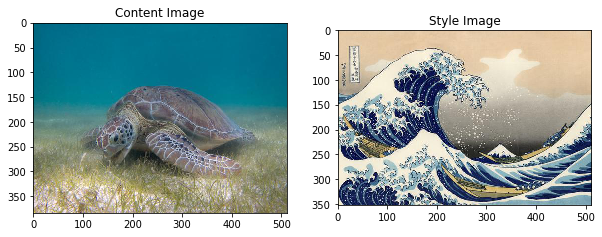

In [13]:
# Show the pictures to work
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [14]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [15]:
'''
In order to obtain both the content and the style representations of our image 
we will see some intermediate layers within our model The intermediate layers represent maps 
of characteristics that are ordered more and more as you go deeper In this case, we are 
using the VGG19 network architecture, a pre-formed image classification network These layers 
intermediates are necessary to define the representation of the content and style of our images.
For an input image, we will try to match the style and content representations 
corresponding in these intermediate layers.
'''
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
"dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
'''
Within our preconfigured image classification network we can define the representations of
style and content. At a high level, this phenomenon can be explained by the fact that for a network to perform
the classification of images (for which our network has been trained), you must understand the image This implies
take the raw image as input pixels and build an internal representation through transformations
that convert the raw image pixels into a complex understanding of the characteristics present within the image. This is also partly why convolutional neural networks are able to generalize well: they are able to capture invariants and define characteristics within classes (e.g., cats vs. dogs) that are agnostic to background noise and other disturbances. Thus, somewhere between the input of the raw image and the output of the classification label, the model serves as an extractor of complex characteristics; thus, by accessing intermediate layers, we can describe the content and style of the input images.
'''

# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [17]:
def get_model():
    """ Creates our model with access to intermediate layers. 
  
      This function will load the VGG19 model and access the intermediate layers. 
      These layers will then be used to create a new model that will take input image
      and return the outputs from these intermediate layers from the VGG model. 
  
      Returns:
        returns a keras model that takes image inputs and outputs the style and 
          content intermediate layers. 
    """
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # Build model 
    return models.Model(vgg.input, model_outputs)

In [18]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [19]:
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
  
    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [20]:
def get_feature_representations(model, content_path, style_path):
    """Helper function to compute our content and style feature representations.

    This function will simply load and preprocess both the content and style 
    images from their path. Then it will feed them through the network to obtain
    the outputs of the intermediate layers. 
    
    Arguments:
        model: The model that we are using.
        content_path: The path to the content image.
        style_path: The path to the style image
    
    Returns:
        returns the style features and the content features. 
      """
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
  
    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
  
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [21]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.
      Arguments:
        model: The model that will give us access to the intermediate layers
               loss_weights: The weights of each contribution of each loss function. 
               (style weight, content weight, and total variation weight)
               init_image: Our initial base image. This image is what we are updating with 
               our optimization process. We apply the gradients wrt the loss we are 
               calculating to this image.
      gram_style_features: Precomputed gram matrices corresponding to the 
                           defined style layers of interest.
      content_features: Precomputed outputs from defined content layers of interest.
      
      Returns:
        returns the total loss, style loss, content loss, and total variational loss
  """
    style_weight, content_weight = loss_weights
  
    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)
  
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
  
    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [22]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [23]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false. 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
  
    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    # Create our optimizer # now use tf.optimizers.Adam 
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    iter_count = 1
  
    # Store our best result
    best_loss, best_img = float('inf'), None
  
    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }
    
    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()
      
            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss

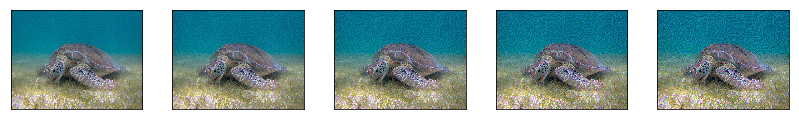

In [24]:
# works Adam YEA!, Obviously, the higher the number of iterations, the more style transference will have the final 
# result,  it is worth mentioning that the computing power increases and therefore the time as well.
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=5)

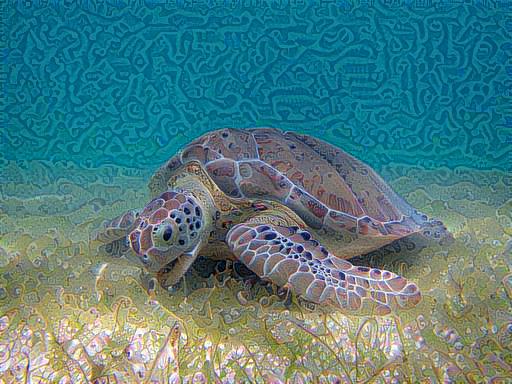

In [25]:
Image.fromarray(best)

In [26]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path) 
    style = load_img(style_path)
    
    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

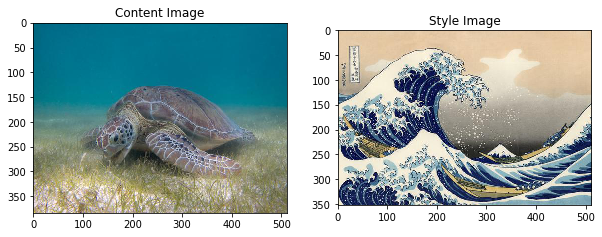

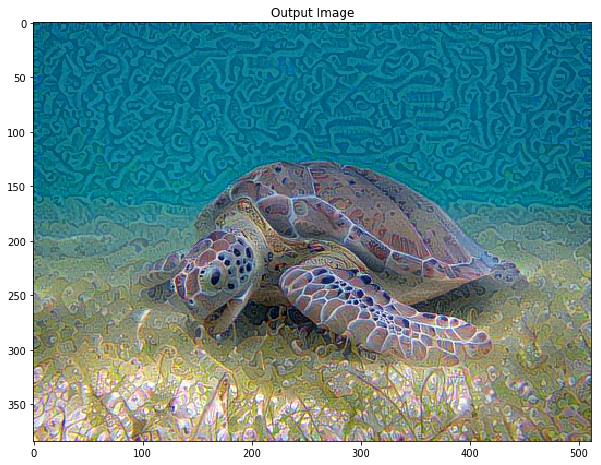

In [27]:
show_results(best, content_path, style_path)